# Part 3: Zonal Statistics and Comparative Analysis

In this third section of the assignment project, the code uses libraries like `rasterstats` to perform zonal statistics. The latter is a set of analytical techniques used in Geographic Information Systems (GIS) to calculate statistics on values from a **raster dataset** within **zones** defined by another dataset. These zones can be defined by features such as polygons in a vector layer or by areas of consistent value in a raster layer. We will use the **join** shapefile produced in Part 1 of the code to define such zones, so as to obtain mean NDVI and habitat connectivity values for each agricultural plot. This process facilitates a comprehensive analysis of vegetation health and landscape connectivity, which are critical for sustainable agricultural management. By integrating NDVI and connectivity data, we can evaluate the ecological value of agricultural lands, informing strategies to enhance biodiversity conservation within agricultural practices.

First, let's load all the files necessary for this part of the project.

In [4]:
import rasterio as rio

#Open the .tif which contains the NDVI calculation from Part 2
ndvi_path="Data_files/Output_files/clipped_ndvi.tif"
ndvi=rio.open(ndvi_path)

import geopandas as gpd

#load the join shapefile from Part 1
join_path = 'Data_files/Output_files/joined_with_area.shp'
join = gpd.read_file(join_path)

## Calculating NDVI Statistics

### Checking CRS
Before we can perform zonal statistics, we want to make sure that the coordinate reference system (CRS) of the **join** shapefile is the same as the CRS of the **NDVI** raster data. This is crucial as spatial operations require both datasets to be in the same CRS to ensure accurate analysis. 

In [21]:
ndvi_crs = ndvi.crs
print(f"NDVI CRS: {ndvi_crs}")


join_crs = join.crs
print(f"Join CRS: {join_crs}")

NDVI CRS: PROJCS["UTM Zone 33, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Join CRS: EPSG:32633


In this case, our raster and vector files share the same CRS (EPSG:32633). However, if the Coordinate Reference System (CRS) of your join shapefile does not match the CRS of the NDVI raster data, you need to perform a CRS transformation or re-projection. The **my_functions.py** file contains the `transform_raster` function which was defined to reproject raster data to a new Coordinate Reference System (CRS). This can be used if the CRS of your raster data does not match the CRS of another dataset you wish to analyze together, such as when performing zonal statistics. We can use the `help()` function to have a better look at how it works:

In [2]:
from my_functions import transform_raster
help(transform_raster)

Help on function transform_raster in module my_functions:

transform_raster(raster_path, target_crs)
    This function takes a raster file path and a target Coordinate Reference System (CRS) as inputs.
    It opens the raster file, reads the data, and gets the bounds of the raster.
    Then, it calculates the transform and the new dimensions for the reprojected data.
    It creates a new array for the reprojected data and performs the reprojection.
    Finally, it calculates the new bounds of the reprojected data and returns the reprojected data,
    the new transform, and the new bounds.

    Parameters:
    raster_path (str): The path to the raster file.
    target_crs (dict): The target CRS in proj4 format.

    Returns:
    dst_img (numpy.ndarray): The reprojected raster data.
    transform (affine.Affine): The transform of the reprojected data.
    (new_left, new_bottom, new_right, new_top) (tuple): The bounds of the reprojected data.



### Zonal Statistics
After this, we can proceed to define the parameters to calculate zonal statistics and append results to a shapefile. The code below defines the `calculate_zonal_stats` function which does the following:
1. **Reproject Vector Data**: The function starts by reprojecting the vector data (join) to match the CRS of the raster data (raster). This ensures that both datasets are spatially aligned for accurate analysis.
2. **Read Raster Data**: It reads the first band of the raster data into an array and retrieves the affine transformation, which defines the raster’s position in space.
3. **Calculate Zonal Statistics**: Using the zonal_stats function from the rasterstats library, it calculates statistical measures (mean, minimum, maximum, and standard deviation) for each zone in the vector dataset based on the values of the raster data.
4. **Create DataFrame**: The results of the zonal statistics are then converted into a pandas DataFrame for easy manipulation and analysis.
5. **Merge Results**: The statistical results are merged back into the original vector dataset (join) with a suffix added to the column names to distinguish them.
6. **Save to GeoJSON**: The updated vector data, now containing the zonal statistics, is saved to a GeoJSON file, which is a common format for representing geospatial data.
7. **Print Confirmation**: Finally, the function prints a message confirming the successful calculation and saving of the zonal statistics.

In [2]:
from rasterstats import zonal_stats
import pandas as pd

def calculate_zonal_stats(join, raster, suffixes):
    temp = join.to_crs(crs=raster.crs.data)

    # Define the parameters to calculate the zonal statistics
    array = raster.read(1)
    affine = raster.transform
    zs = zonal_stats(temp, array, affine=affine, stats=['mean', 'min', 'max', 'std'])

    # Append the results to a pandas' dataframe
    df = pd.DataFrame(zs)

    # Specify suffixes for overlapping columns
    join = join.join(df.add_suffix(suffixes))
    join.to_file(f"Data_files/Output_files/ZonalStats{suffixes}_Polygons.geojson", driver='GeoJSON')

    print(f"Zonal statistics calculated successfully for {suffixes} and saved to GeoJSON file.")

# Now you can call the function with your join, raster and suffix
calculate_zonal_stats(join, ndvi, "_ndvi")

C:\Users\M533\anaconda3\envs\Assignment\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Zonal statistics calculated successfully for _ndvi and saved to GeoJSON file.


In [7]:
join_path = 'Data_files/Output_files/ZonalStats_ndvi_Polygons.geojson'
join = gpd.read_file(join_path)
join.head()

,CODICE,DESC_,Plot_ha,index_righ,R_LEGISL,NAME,CODEAP,decree,Publ,Area_ha,management,CLASS,int_ha,min_ndvi,max_ndvi,mean_ndvi,std_ndvi,geometry
0,221,vineyards,0.395399,NaN,None,None,None,None,None,NaN,None,None,0.000000,0.327657,0.434018,0.378990,0.044254,"POLYGON Z ((647468.894 4520416.843 0.000, 6474..."
1,221,vineyards,0.507260,0.0,L. n. 426 del 09.12.1998,Parco nazionale dell'Alta Murgia,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,Ente Parco Nazionale dell' Alta Murgia,Parchi nazionali e riserve naturali statali,0.507260,0.507952,0.589666,0.555148,0.026326,"POLYGON Z ((640443.620 4528059.830 0.000, 6404..."
2,221,vineyards,0.451273,0.0,L. n. 426 del 09.12.1998,Parco nazionale dell'Alta Murgia,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,Ente Parco Nazionale dell' Alta Murgia,Parchi nazionali e riserve naturali statali,0.446702,0.413714,0.527211,0.460763,0.042743,"POLYGON Z ((644611.482 4519606.510 0.000, 6445..."
3,222,orchards and minor fruits,4.685679,0.0,L. n. 426 del 09.12.1998,Parco nazionale dell'Alta Murgia,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,Ente Parco Nazionale dell' Alta Murgia,Parchi nazionali e riserve naturali statali,4.685679,0.449516,0.687204,0.535846,0.045776,"POLYGON Z ((646206.803 4523193.705 0.000, 6462..."
4,222,orchards and minor fruits,0.335897,NaN,None,None,None,None,None,NaN,None,None,0.000000,0.507552,0.621312,0.564432,0.056880,MULTIPOLYGON Z (((647587.885 4524979.883 0.000...


### Visualizing NDVI mean values of Agricultural Plots
Now we can visualise the agricultural plots by mean_ndvi values using `matplotlib.pyplot`.

Text(0.5, 1.0, 'Mean NDVI by Agricultural Plot')

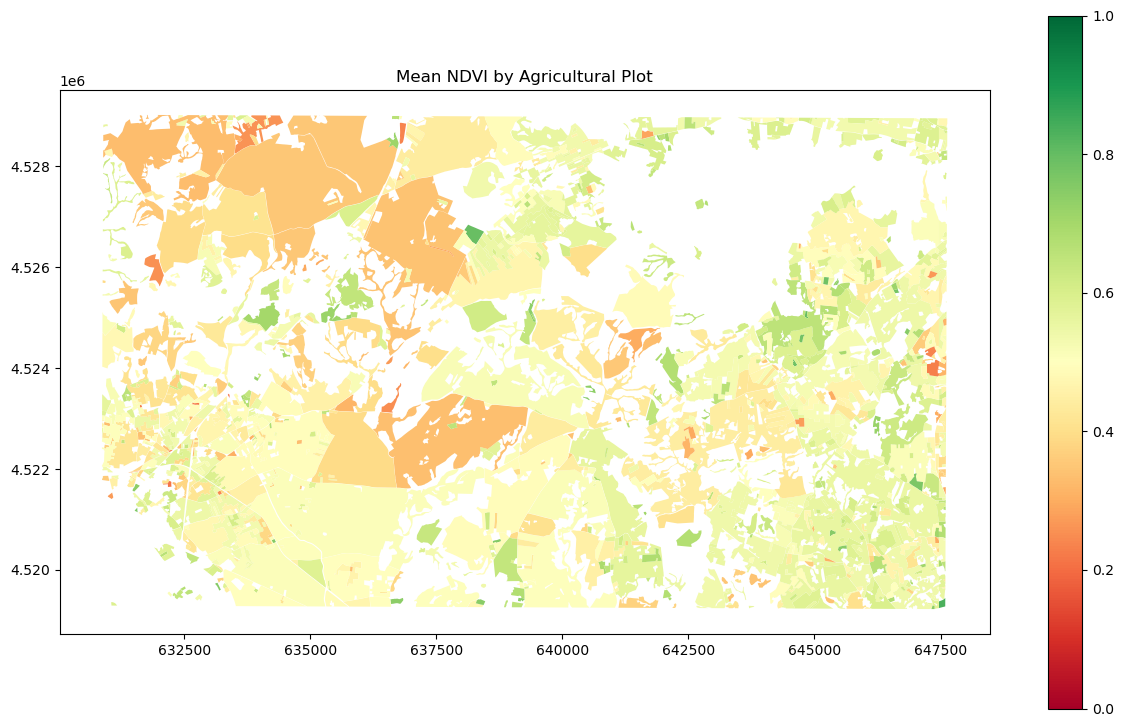

In [8]:
import matplotlib.pyplot as plt
meanmap = join.plot(column='mean_ndvi', cmap =    
                                'RdYlGn', vmin=0, vmax=1, figsize=(15,9), legend =  
                                  True);
plt.title("Mean NDVI by Agricultural Plot")

## Habitat Connectivity

**Habitat connectivity** refers to the degree to which different patches of habitat are connected, affecting the movement, distribution, genetic diversity, and overall health of animal and plant populations. It is a critical aspect of conservation biology, as it allows for the movement of species in search of food, mates, and new habitats, which is essential for maintaining biodiversity, ecological functions, and resilience against environmental changes. 

The presented project uses habitat connectivity data developed as part of my [BSc dissertation research](https://www.linkedin.com/posts/mariavittoria-santarelli_sustainableagriculture-agroecological-community-activity-6954342396763504641-3Ndx?utm_source=share&utm_medium=member_desktop). The latter produced habitat connectivity maps for a defined rural bird species (*Lanius Senator*, also known as Woodchat Shrike). These will be used to extract habitat connectivity values for agricultural plots and explore any potential relationship with NDVI. This is done on the grounds that NDVI is a measure of vegetation greenness and health, and it can be an important predictor in habitat selection for certain species during migration. For instance, areas with higher NDVI values may indicate more suitable habitats or corridors for wildlife movement. 

The code below quickly loads and plots the habitat connectivity map using `matplotlib.pyplot`. The map loads data for the whole Apulia region, so we will need to clip this to our AOI.

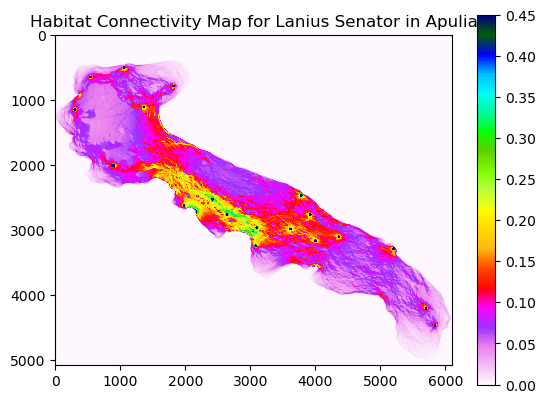

In [9]:
hab_con_path="Data_files/habmap.tif"
with rio.open(hab_con_path) as src:
    hab_con_data = src.read()

plt.imshow(hab_con_data[0], cmap='gist_ncar_r', vmin=0, vmax=0.45)
plt.colorbar()
plt.title('Habitat Connectivity Map for Lanius Senator in Apulia')
plt.show()

### Clipping Habitat Connectivity to AOI

Before we can clip our Habitat Connectivity raster to our AOI shapefile we need to check that the latter are in the same coordinate system.

In [10]:
hab_con_path="Data_files/habmap.tif"
with rio.open(hab_con_path) as hab_con_src:
    raster_crs = hab_con_src.crs
    print(f"Raster CRS: {raster_crs}")

AOI_path = 'Data_files/Area_of_interest.shp'
AOI = gpd.read_file(AOI_path)
vector_crs = AOI.crs
print(f"Vector CRS: {vector_crs}")

Raster CRS: EPSG:32633
Vector CRS: EPSG:32633


The code below uses the `clip_raster_to_aoi` function from **my_functions.py** to clip the Habitat Connectivity raster to our AOI.

In [14]:
from my_functions import clip_raster_to_aoi 

clip_raster_to_aoi(hab_con_path, AOI_path, 'Data_files/Output_files/clipped_habmap.tif')

Clipped raster saved to Data_files/Output_files/clipped_habmap.tif


### Visualizing Habitat Connectivity Raster

Now we can plot the clipped Habitat Connectivity raster to visualise it using `matplotlib.pyplot`. Habitat Connectivity maps normally range between 0 and 1, with 0 being areas that are impermeable to animal movement, and 1 being patch habitat area (i.e. of maximum connectivity). For better visualization we can adjust the `vmax` argument so that our data is easier to interpret. In the plot below, areas of low connectivity are in blue, while areas with higher connectvity are displayed in colors from red to purple. 

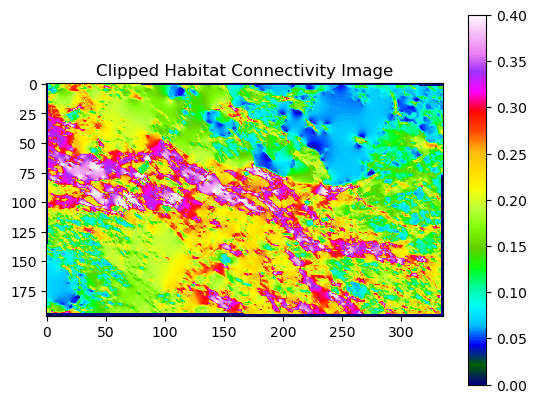

In [15]:
clipped_habmap_path = 'Data_files/Output_files/clipped_habmap.tif'
with rio.open(clipped_habmap_path) as src:
    clipped_habmap_data = src.read()
    
plt.imshow(clipped_habmap_data[0], cmap='gist_ncar', vmin=0, vmax=0.4)
plt.colorbar()
plt.title('Clipped Habitat Connectivity Image')
plt.show()

### Calculating Habitat Connectivity Statistics 

Now we can perform again zonal statistics using `zonal_stats` as above. This time we will use the GeoJSON file with NDVI values as the file to use in the join.

In [32]:
# Open the .tif which contains the clipped habitat connectivity map
clipped_habmap_path = 'Data_files/Output_files/clipped_habmap.tif'
habcon=rio.open(clipped_habmap_path)
calculate_zonal_stats(join, habcon, "_hab")

Zonal statistics calculated successfully for _hab and saved to GeoJSON file.


In [24]:
join_path = 'Data_files/Output_files/ZonalStats_hab_Polygons.geojson'
join = gpd.read_file(join_path)
join.head()

,CODICE,DESC_,Plot_ha,index_righ,R_LEGISL,NAME,CODEAP,decree,Publ,Area_ha,...,int_ha,min_ndvi,max_ndvi,mean_ndvi,std_ndvi,min_hab,max_hab,mean_hab,std_hab,geometry
0,221,vineyards,0.395399,NaN,None,None,None,None,None,NaN,...,0.000000,0.327657,0.434018,0.378990,0.044254,0.151066,0.151066,0.151066,0.000000,"POLYGON Z ((647468.894 4520416.843 0.000, 6474..."
1,221,vineyards,0.507260,0.0,L. n. 426 del 09.12.1998,Parco nazionale dell'Alta Murgia,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,...,0.507260,0.507952,0.589666,0.555148,0.026326,0.107919,0.200057,0.139799,0.042633,"POLYGON Z ((640443.620 4528059.830 0.000, 6404..."
2,221,vineyards,0.451273,0.0,L. n. 426 del 09.12.1998,Parco nazionale dell'Alta Murgia,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,...,0.446702,0.413714,0.527211,0.460763,0.042743,0.096936,0.106752,0.101844,0.004908,"POLYGON Z ((644611.482 4519606.510 0.000, 6445..."
3,222,orchards and minor fruits,4.685679,0.0,L. n. 426 del 09.12.1998,Parco nazionale dell'Alta Murgia,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,...,4.685679,0.449516,0.687204,0.535846,0.045776,0.118485,0.150945,0.133325,0.010309,"POLYGON Z ((646206.803 4523193.705 0.000, 6462..."
4,222,orchards and minor fruits,0.335897,NaN,None,None,None,None,None,NaN,...,0.000000,0.507552,0.621312,0.564432,0.056880,0.100114,0.100114,0.100114,0.000000,MULTIPOLYGON Z (((647587.885 4524979.883 0.000...


### Visualizing Habitat Connectivity mean values of Agricultural Plots
Now we can visualise the agricultural plots by mean_hab values using `matplotlib.pyplot`.

Text(0.5, 1.0, 'Mean Habitat Connectivity by Agricultural Plot')

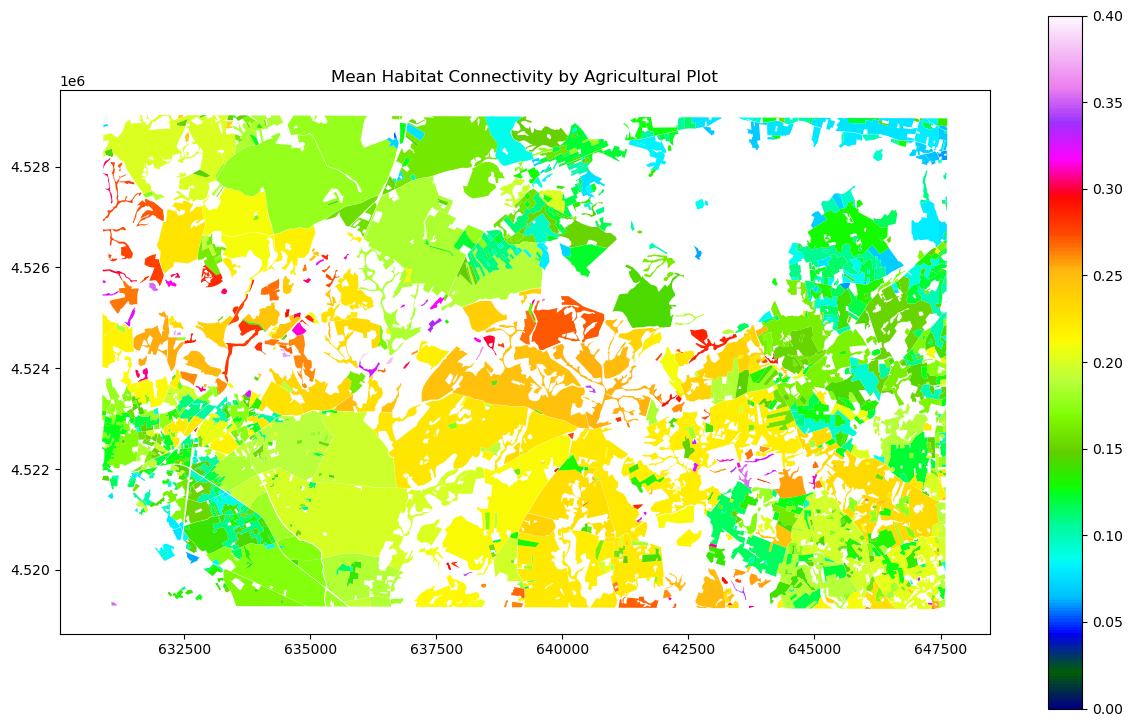

In [35]:
meanmap = join.plot(column='mean_hab', cmap =    
                                'gist_ncar', vmin=0, vmax=0.4, figsize=(15,9), legend =  
                                  True);
plt.title("Mean Habitat Connectivity by Agricultural Plot")

## Comparative Analysis of NDVI and Habitat Connectivity

Our final GeoDataFrame **join** now contains enough data to perform some comparative and statistical analysis.

### Summary Statistics

First of all we can look at different summary stats per management type using the `groupby` function.
#### Mean NDVI per Management Type

In [37]:
join.groupby('DESC_')['mean_ndvi'].mean()

DESC_
areas mainly occupied by agricultural crops with the presence of natural spaces    0.439219
complex cultivation and parcel systems                                             0.501937
olive groves                                                                       0.525399
orchards and minor fruits                                                          0.545724
other permanent crops                                                              0.545372
simple arable land in non-irrigated areas                                          0.503872
surfaces with dense herbaceous cover                                               0.535391
temporary crops associated with permanent crops                                    0.471157
vineyards                                                                          0.463011
Name: mean_ndvi, dtype: float64

#### Mean Habitat Connectivity per Management Type

In [38]:
join.groupby('DESC_')['mean_hab'].mean()

DESC_
areas mainly occupied by agricultural crops with the presence of natural spaces    0.191977
complex cultivation and parcel systems                                             0.164348
olive groves                                                                       0.136917
orchards and minor fruits                                                          0.160725
other permanent crops                                                              0.074210
simple arable land in non-irrigated areas                                          0.195457
surfaces with dense herbaceous cover                                               0.122973
temporary crops associated with permanent crops                                    0.193085
vineyards                                                                          0.118985
Name: mean_hab, dtype: float64

### Statistical Correlations between NDVI and Habitat Connectivity
We can also calculate the statistical correlation between variables. 

#### Pearson's and Spearman's Correlations
The code below uses the `.corr` function in the `pandas` library to calculate and print (rounded to 2 decimal places) the Pearson's and Spearman's correlation coefficients between NDVI and Habitat Connectivity values.

In [25]:
correlation = join['mean_ndvi'].corr(join['mean_hab'])
print(f"Pearson's correlation coefficient: {correlation:.2f}")

spearman_corr = join['mean_ndvi'].corr(join['mean_hab'], method='spearman')
print(f"Spearman's rank correlation coefficient: {spearman_corr:.2f}")

Pearson's correlation coefficient: -0.07
Spearman's rank correlation coefficient: -0.08


#### Pearson's and Spearman's Correlation per Management Type

In our analysis, we can extend our investigation to include the impact of different **management types** on the relationship between NDVI (Normalized Difference Vegetation Index) and Habitat Connectivity. Both of these factors can be influenced by how the land is managed. For instance, certain management practices might enhance both vegetation health and habitat connectivity, leading to a positive correlation between NDVI and Habitat Connectivity. On the other hand, some management types might improve one at the expense of the other, resulting in a negative correlation.

By calculating the statistical correlation separately for each management type using the `groupby` function, the code below explores whether the management practices influence the correlation between these two variables. The code below only calculates the correlation for groups with more than two rows of data, as less than this wouldn't produce significant results, and assigns the value None for groups with less than two rows. The `include_groups=False` argument was used to silence the deprecation warnings.

In [41]:
Pearson_by_group = join.groupby('DESC_').apply(lambda group: group['mean_ndvi'].corr(group['mean_hab']) if len(group) > 2 else None, include_groups=False)

Spearman_by_group = join.groupby('DESC_').apply(lambda group: group['mean_ndvi'].corr(group['mean_hab'], method='spearman') if len(group) > 2 else None, include_groups=False)

print("Pearson's Correlation by Management Type:")
print(Pearson_by_group)

print("Spearman's Correlation by Management Type:")
print(Spearman_by_group)

Pearson's Correlation by Management Type:
DESC_
areas mainly occupied by agricultural crops with the presence of natural spaces         NaN
complex cultivation and parcel systems                                             0.760073
olive groves                                                                       0.054339
orchards and minor fruits                                                         -0.020166
other permanent crops                                                                   NaN
simple arable land in non-irrigated areas                                         -0.072249
surfaces with dense herbaceous cover                                              -0.487620
temporary crops associated with permanent crops                                   -0.241199
vineyards                                                                         -0.117038
dtype: float64
Spearman's Correlation by Management Type:
DESC_
areas mainly occupied by agricultural crops with the presenc

### Statistical Correlations between Intersection Area with PAs and Habitat Connectivity

Another thing that we can look at is the correlation between intersection area with **Protected Areas** (PAs) and habitat connectivity. This is a valuable avenue of investigation as it allows us to understand how protected regions interact with the overall connectivity of habitats. 

Protected Areas often serve as crucial nodes in habitat networks, providing safe havens for biodiversity and facilitating species movement across landscapes. Therefore, the size of the intersection area with PAs can potentially influence habitat connectivity. By calculating the correlation between the intersection area with PAs and habitat connectivity, we can quantify this relationship. A positive correlation might suggest that larger intersection areas with PAs are associated with higher habitat connectivity, indicating the role of PAs in enhancing landscape connectivity. Conversely, a negative correlation could point towards other factors at play, such as the location and distribution of PAs, that might be impacting habitat connectivity.

In [42]:
correlation = join['int_ha'].corr(join['mean_hab'])
print(f"Pearson's correlation coefficient: {correlation:.2f}")

spearman_corr = join['int_ha'].corr(join['mean_hab'], method='spearman')
print(f"Spearman's rank correlation coefficient: {spearman_corr:.2f}")

Pearson's correlation coefficient: 0.02
Spearman's rank correlation coefficient: -0.00


This is the end of Part 3 of the code. The [next and last section](ScriptP4.ipynb) uses different tools to display the obtained results.